# **Práctica 2. Procesamiento de datos mediante Apache Spark**

**Autores**:

- Carlos Vigil González                 100363974
- David Gil López                       100363815
- Daniel Alejandro Rodríguez López      100316890


# Introducción 


En este trabajo se van a analizar una serie de datos sobre los Taxis de la Ciudad de Nueva York utilizando Apache Spark y Python (PySpark), todo ello ejecutado en este Jupyter Notebook.

***
En este caso se ha utilizado la versión 3 de Apache Spark para el desarrollo del código y sus pruebas.
***

En los apartados siguientes se van a ir comentando diferentes aspectos de la práctica, empezando con una limpieza de los datos de entrada, continuando con los diferentes análisis de dichos datos, para acabar con unas conclusiones sobre los tiempos de ejecución de cada estudio y sus velocidades, comparándolas entre si para ver por qué unos se ejecutan más rápido que otros.

# Código para ejecutar en google collab

***
Aquí dejamos el código para ejecutar el notebook en google collab. Para ello bastaría con descomentar el bloque de abajo.
***

In [1]:
import os
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
#!tar xf /content/spark-3.0.1-bin-hadoop2.7.tgz
#!pip install -q findspark
#

#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

# Imports

In [2]:
import sys
is_conda = os.path.exists(os.path.join(sys.prefix, 'conda-meta'))

if not is_conda:
    import findspark 
    findspark.init()

from IPython.core.display import display, HTML
from IPython.display import IFrame
from collections import defaultdict
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, datediff, unix_timestamp
from time import time
import csv
import matplotlib.pyplot as plt
import numpy as np

# Para una lectura más distendida de la memoria
MODO_JAJAS = False

# Lectura de datos

En este apartado se incluye una función para facilitar la creación de las posteriores gráficas y la creación del entorno de spark con la lectura del CSV inicial.

In [3]:
def autolabel(rects):
    # https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", fontsize=25,
                    ha='center', va='bottom')

In [4]:
if MODO_JAJAS:
    display(IFrame("https://giphy.com/embed/I1U9DTjCqOF3i",width="240", height="135"))

In [5]:
spark = SparkSession.builder.appName("taxis").master("local[*]").getOrCreate()

In [6]:
t0 = time()
# Como el dataset está en AG, pues no se puede hacer un wget super-molón
# así que hay que tenerlo descargado de antes
df = spark.read.csv('./tripdata_2017_01.csv', header=True, inferSchema=True)

In [7]:
df.printSchema()
dfP=df.toPandas()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



# Limpieza de datos

En este apartado se limpian los datos de entrada, para que a la hora de procesarlos no salgan valores fuera de lo esperado.

In [8]:
if MODO_JAJAS:
    display(IFrame("https://giphy.com/embed/xsATxBQfeKHCg", width="240", height="180"))

In [9]:
initial_data_count = df.count()
print("Cantidad de datos usados:", initial_data_count)
display(dfP)
display(dfP.describe().T)

Cantidad de datos usados: 971010


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2017-01-09 11:13:28,2017-01-09 11:25:45,1,3.30,1,N,263,161,1,12.5,0.0,0.5,2.00,0.00,0.3,15.30
1,1,2017-01-09 11:32:27,2017-01-09 11:36:01,1,0.90,1,N,186,234,1,5.0,0.0,0.5,1.45,0.00,0.3,7.25
2,1,2017-01-09 11:38:20,2017-01-09 11:42:05,1,1.10,1,N,164,161,1,5.5,0.0,0.5,1.00,0.00,0.3,7.30
3,1,2017-01-09 11:52:13,2017-01-09 11:57:36,1,1.10,1,N,236,75,1,6.0,0.0,0.5,1.70,0.00,0.3,8.50
4,2,2017-01-01 00:00:00,2017-01-01 00:00:00,1,0.02,2,N,249,234,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971005,2,2017-01-17 13:16:22,2017-01-17 13:35:14,1,3.43,1,N,264,264,2,14.5,0.0,0.5,0.00,0.00,0.3,15.30
971006,2,2017-01-17 13:16:23,2017-01-17 13:23:01,1,0.78,1,N,161,237,1,6.0,0.0,0.5,1.36,0.00,0.3,8.16
971007,2,2017-01-17 13:16:23,2017-01-17 13:23:51,1,0.95,1,N,237,229,2,6.5,0.0,0.5,0.00,0.00,0.3,7.30
971008,2,2017-01-17 13:16:23,2017-01-17 13:32:45,1,1.68,1,N,170,48,1,11.5,0.0,0.5,2.46,0.00,0.3,14.76


,count,mean,std,min,25%,50%,75%,max
VendorID,971010.0,1.556951,0.496746,1.00,1.00,2.00,2.00,2.00
passenger_count,971010.0,1.685989,1.291705,0.00,1.00,1.00,2.00,9.00
trip_distance,971010.0,3.031285,3.785847,0.00,1.00,1.70,3.25,151.70
RatecodeID,971010.0,1.044729,0.461631,1.00,1.00,1.00,1.00,99.00
PULocationID,971010.0,160.378031,67.938198,1.00,113.00,161.00,231.00,265.00
DOLocationID,971010.0,158.556712,72.276821,1.00,100.00,161.00,233.00,265.00
payment_type,971010.0,1.371974,0.503326,1.00,1.00,1.00,2.00,4.00
fare_amount,971010.0,13.108188,546.736933,-120.00,6.50,9.00,14.00,538579.20
extra,971010.0,0.209993,0.261634,-1.00,0.00,0.00,0.50,55.54
mta_tax,971010.0,0.497214,0.040586,-0.50,0.50,0.50,0.50,0.50


### Elementos extraños en el dataset

Lista de comportamientos extraños en los datos, y por tanto, inválidos a la hora de utilizarlos, ya que deberían ser coherentes basándonos en la información de cada campo proporcionada por la [documentación](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

* Existen carreras en las que la distancia es 0
* Existen propinas negativas
* "extra" con valores diferentes a 0 (ya que puede no haber extras), 0.5 y 1
* Existen viajes con un precio final negativo
* "MTA_tax" debe valer siempre 0.50. Valores diferentes son erróneos, y por tanto puede que el resto de la información también
* "Improvement_surcharge" es un valor en desuso, por lo que debería valer en el menor caso 0, no -0.3
* Carreras cuya fecha de fin sea igual o anterior a la fecha de inicio
* Existen tarifas con valores negativos. No tiene sentido ya que la tarifa va en función del tiempo y la distancia recorridas

### Elementos extraños PERO posibles

* Número de pasajeros es 0. Dado que es un valor que introduce el propio conductor, valores como 0 son posibles si al conductor le da igual introducir bien el valor.
* Un viaje empieza y acaba en la misma zona. Puede deberse a zonas grandes o que son viajes de ida y vuelta.



### Limpieza realizada

A partir de los comportamientos observados se ha procedido a eliminar las carreras que cumplen las siguientes condiciones:

- Campo "tip_amount" con valores menor a 0
- Campo "total_amount" con valores menor o igual a 0
- Campo "trip_distance" con valores menor o igual a 0
- Campo "fare_amount" con valores menor o igual a 0
- Campo "extra" con valores diferentes de 0, 0.5 y 1
- Campo "MTA_tax" con valor distinto de 0.5
- Campo "Improvement_surcharge" con valor distinto de 0 o 0.3
- Campo "tpep_dropoff_datetime" es anterior o igual a "tpep_pickup_datetime"

In [10]:
# Convertimos las fechas a timestamp, para que dejen de ser strings a secas
# y guardamos su diferencia para luego tener más fácil el filtrado y otros cálculos

df = df.withColumn(
    "tpep_pickup_timestamp", unix_timestamp(col("tpep_pickup_datetime").cast("timestamp"))
).withColumn(
    "tpep_dropoff_timestamp", unix_timestamp(col("tpep_dropoff_datetime").cast("timestamp"))
).withColumn(
    "time_diff", col("tpep_dropoff_timestamp") - col("tpep_pickup_timestamp")  # Segundos
)

df.createOrReplaceTempView('datosCarreras')

In [11]:
datosLimpios = spark.sql("""
    SELECT * FROM datosCarreras WHERE
        tip_amount >= 0 AND
        total_amount > 0 AND
        trip_distance > 0 AND
        fare_amount > 0 AND
        (extra == 0 OR extra == 0.5 OR extra == 1) AND
        mta_tax == 0.5 AND
        improvement_surcharge >= 0 AND
        time_diff > 0
""")
datosLimpios_count = datosLimpios.count()
datosLimpios.createOrReplaceTempView('datosCarrerasLimpios')


In [12]:
# display(datosLimpiosP)
# display(datosLimpiosP.describe().T)

## Extracción de información

Ahora que ya hemos limpiado los datos y tenemos entradas coherentes, se puede proceder a extraer información de los mismos. 

La información que se va a extraer es:

* Velocidad media de los taxis en función de la hora.
* Viajes en taxi más comunes
* Registro financiero: Propinas en función de la hora
* Zonas con poca cobertura



In [13]:
# Bajamos el csv con la información de las zonas para luego poder "traducir"
if not os.path.exists("taxi+_zone_lookup.csv"):
    !wget https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv

In [14]:
# Se añade al dataframe los datos de las zonas de subida y bajada. Para ello se va a realizar un join,
# De forma que vaya dentro del dataframe y sea accesible también desde un rdd

df_lookup = spark.read.csv('./taxi+_zone_lookup.csv', header=True, inferSchema=False)

datosLimpios = datosLimpios.withColumn(
    "LocationID", col("PULocationID")
).join(
    # Renombramos para poder luego incluir también las de bajada
    df_lookup.withColumnRenamed("Borough", "PUBorough"
            ).withColumnRenamed("Zone", "PUZone"
            ).withColumnRenamed("service_zone", "PUservice_zone"),
    on=['LocationID']
).withColumn(
    "LocationID", col("DOLocationID")
).join(
    df_lookup.withColumnRenamed("Borough", "DOBorough"
            ).withColumnRenamed("Zone", "DOZone"
            ).withColumnRenamed("service_zone", "DOservice_zone"),
    on=['LocationID']
)

datosLimpios.createOrReplaceTempView('datosCarrerasLimpios')

# datosLimpiosP = datosLimpios.toPandas()
# display(datosLimpiosP)
# display(datosLimpiosP.describe().T)
t_limpieza = time() - t0

### Velocidad media de los taxis

En este apartado se realizará un análisis de la velocidad media de los taxis, para ello se realizará una transformación de millas a metros sabiendo que 1 milla = 1609.344 metros luego dividiéndolo entre la diferencia de tiempo calculada previamente.

In [15]:
if MODO_JAJAS:
    display(IFrame("https://www.youtube.com/embed/4vlVN5r7sKg", width="360", height="202"))

In [16]:
t0velocidades = time()
dfMTS = datosLimpios.withColumn(
    "mean_speed", col("trip_distance")*1609.344/col("time_diff")
)
dfMTS.createOrReplaceTempView('datosCarrerasLimpiosConVelocidad')

In [17]:
dfMTSP = dfMTS.toPandas()
t1velocidades = time()
display(dfMTSP.sort_values(by=["mean_speed"],ascending=False).head(50))
display(dfMTSP.describe().T)

,LocationID,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,tpep_pickup_timestamp,tpep_dropoff_timestamp,time_diff,PUBorough,PUZone,PUservice_zone,DOBorough,DOZone,DOservice_zone,mean_speed
691398,79,1,2017-01-01 23:02:31,2017-01-01 23:02:32,1,20.50,2,N,79,79,...,1483308151,1483308152,1,Manhattan,East Village,Yellow Zone,Manhattan,East Village,Yellow Zone,32991.552000
725483,63,1,2017-01-16 16:35:18,2017-01-16 16:35:19,1,19.60,1,N,63,63,...,1484580918,1484580919,1,Brooklyn,Cypress Hills,Boro Zone,Brooklyn,Cypress Hills,Boro Zone,31543.142400
571491,150,1,2017-01-15 19:39:26,2017-01-15 19:39:27,1,19.10,1,N,150,150,...,1484505566,1484505567,1,Brooklyn,Manhattan Beach,Boro Zone,Brooklyn,Manhattan Beach,Boro Zone,30738.470400
308536,164,1,2017-01-14 22:59:52,2017-01-14 22:59:53,1,17.40,1,N,164,164,...,1484431192,1484431193,1,Manhattan,Midtown South,Yellow Zone,Manhattan,Midtown South,Yellow Zone,28002.585600
825394,148,1,2017-01-16 23:48:05,2017-01-16 23:48:08,1,27.30,2,N,148,148,...,1484606885,1484606888,3,Manhattan,Lower East Side,Yellow Zone,Manhattan,Lower East Side,Yellow Zone,14645.030400
669527,142,1,2017-01-01 20:50:01,2017-01-01 20:50:05,1,26.90,2,N,142,142,...,1483300201,1483300205,4,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Lincoln Square East,Yellow Zone,10822.838400
87233,151,1,2017-01-01 17:01:09,2017-01-01 17:01:12,1,19.10,1,N,151,151,...,1483286469,1483286472,3,Manhattan,Manhattan Valley,Yellow Zone,Manhattan,Manhattan Valley,Yellow Zone,10246.156800
688967,132,1,2017-01-01 22:46:25,2017-01-01 22:46:27,1,12.00,1,N,132,132,...,1483307185,1483307187,2,Queens,JFK Airport,Airports,Queens,JFK Airport,Airports,9656.064000
597025,132,1,2017-01-15 21:22:57,2017-01-15 21:23:00,1,17.40,1,N,132,132,...,1484511777,1484511780,3,Queens,JFK Airport,Airports,Queens,JFK Airport,Airports,9334.195200
525894,132,1,2017-01-15 16:57:12,2017-01-15 16:57:15,1,17.40,1,N,132,132,...,1484495832,1484495835,3,Queens,JFK Airport,Airports,Queens,JFK Airport,Airports,9334.195200


,count,mean,std,min,25%,50%,75%,max
LocationID,961150.0,1.586092e+02,71.978933,1.000000e+00,1.000000e+02,1.610000e+02,2.320000e+02,2.650000e+02
VendorID,961150.0,1.557943e+00,0.496632,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
passenger_count,961150.0,1.687589e+00,1.293372,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,6.000000e+00
trip_distance,961150.0,3.016129e+00,3.696633,1.000000e-02,1.000000e+00,1.700000e+00,3.250000e+00,1.391700e+02
RatecodeID,961150.0,1.026247e+00,0.188597,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00
PULocationID,961150.0,1.603090e+02,67.864522,1.000000e+00,1.130000e+02,1.610000e+02,2.310000e+02,2.650000e+02
DOLocationID,961150.0,1.586092e+02,71.978933,1.000000e+00,1.000000e+02,1.610000e+02,2.320000e+02,2.650000e+02
payment_type,961150.0,1.368578e+00,0.498094,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00
fare_amount,961150.0,1.233191e+01,10.246143,2.000000e-01,6.500000e+00,9.000000e+00,1.400000e+01,3.500000e+02
extra,961150.0,2.111528e-01,0.255421,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00


En vista de que las velocidades medias estaban mal debido a que el time_diff es muy bajo, probablemente por un error de los tiempos almacenador por los taxistas, se volverá a realizar una consulta eliminando tiempos menores a 3 minutos y se volverá a comprobar las velocidades promedio, ya que nos parece coherente que para poder considerar una carrera de taxi, carrera, al menos debería durar más de un suspiro.


In [18]:
t2velocidades = time()
datosLimpiosSinVelocidades = spark.sql("SELECT * FROM datosCarrerasLimpios where time_diff >= 180")
dfMTS = datosLimpiosSinVelocidades.withColumn(
    "mean_speed", col("trip_distance")*1609.344/col("time_diff")
)

In [19]:
dfMTSP = dfMTS.toPandas()
t3velocidades = time()
display(dfMTSP.sort_values(by=["mean_speed"],ascending=False).head(10))
display(dfMTSP.describe().T)

,LocationID,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,tpep_pickup_timestamp,tpep_dropoff_timestamp,time_diff,PUBorough,PUZone,PUservice_zone,DOBorough,DOZone,DOservice_zone,mean_speed
695619,50,2,2017-01-16 17:18:50,2017-01-16 17:23:34,1,24.58,2,N,132,50,...,1484583530,1484583814,284,Queens,JFK Airport,Airports,Manhattan,Clinton West,Yellow Zone,139.287590
6000,132,1,2017-01-01 08:33:03,2017-01-01 08:38:35,1,26.80,1,N,132,132,...,1483255983,1483256315,332,Queens,JFK Airport,Airports,Queens,JFK Airport,Airports,129.910901
659906,148,2,2017-01-02 02:18:28,2017-01-02 02:26:54,1,27.47,1,N,76,148,...,1483319908,1483320414,506,Brooklyn,East New York,Boro Zone,Manhattan,Lower East Side,Yellow Zone,87.368932
423928,37,1,2017-01-15 12:30:22,2017-01-15 12:33:25,1,8.00,1,N,37,37,...,1484479822,1484480005,183,Brooklyn,Bushwick South,Boro Zone,Brooklyn,Bushwick South,Boro Zone,70.353836
168363,196,1,2017-01-01 06:16:23,2017-01-01 06:19:54,1,8.90,1,N,196,196,...,1483247783,1483247994,211,Queens,Rego Park,Boro Zone,Queens,Rego Park,Boro Zone,67.882282
682256,130,2,2017-01-16 16:24:39,2017-01-16 16:32:56,2,20.61,2,N,132,130,...,1484580279,1484580776,497,Queens,JFK Airport,Airports,Queens,Jamaica,Boro Zone,66.737585
784668,116,2,2017-01-17 01:00:33,2017-01-17 01:03:36,1,6.08,1,N,237,116,...,1484611233,1484611416,183,Manhattan,Upper East Side South,Yellow Zone,Manhattan,Hamilton Heights,Boro Zone,53.468915
880463,165,1,2017-01-17 11:33:42,2017-01-17 11:37:51,1,8.20,1,N,165,165,...,1484649222,1484649471,249,Brooklyn,Midwood,Boro Zone,Brooklyn,Midwood,Boro Zone,52.998477
343612,260,2,2017-01-15 02:19:35,2017-01-15 03:05:08,1,73.80,5,N,170,260,...,1484443175,1484445908,2733,Manhattan,Murray Hill,Yellow Zone,Queens,Woodside,Boro Zone,43.457588
736883,35,1,2017-01-16 19:53:17,2017-01-16 20:01:49,1,12.50,1,N,35,35,...,1484592797,1484593309,512,Brooklyn,Brownsville,Boro Zone,Brooklyn,Brownsville,Boro Zone,39.290625


,count,mean,std,min,25%,50%,75%,max
LocationID,908566.0,1.580280e+02,71.944970,1.000000e+00,1.000000e+02,1.610000e+02,2.310000e+02,2.650000e+02
VendorID,908566.0,1.557853e+00,0.496642,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
passenger_count,908566.0,1.691012e+00,1.294333,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,6.000000e+00
trip_distance,908566.0,3.157709e+00,3.748656,1.000000e-02,1.100000e+00,1.800000e+00,3.400000e+00,1.391700e+02
RatecodeID,908566.0,1.026851e+00,0.188084,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00
PULocationID,908566.0,1.598529e+02,67.616472,1.000000e+00,1.130000e+02,1.610000e+02,2.310000e+02,2.650000e+02
DOLocationID,908566.0,1.580280e+02,71.944970,1.000000e+00,1.000000e+02,1.610000e+02,2.310000e+02,2.650000e+02
payment_type,908566.0,1.360882e+00,0.494393,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00
fare_amount,908566.0,1.279407e+01,10.279671,1.050000e+00,6.500000e+00,9.500000e+00,1.450000e+01,3.500000e+02
extra,908566.0,2.111707e-01,0.255440,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00




Como se puede observar, la mayoría de velocidades entre las 50 más rápidas superan el límite de velocidad nacional para zonas de carretera (24.72222 m/s) siendo solo los 5 últimos lo cumplen, o en otras palabras que los 45 primeros infringen la ley.

Por otro lado se puede ver que los 8 primeros tienen velocidades mayores a 52 metros por segundo, lo que implica velocidades de 187.2 km/h esto puede ser debido a que haya algún tipo de fallo en el tiempo o que lleve velocidades demasiado altas.

Por último mencionar que los 6 primeros tienen velocidades mayores a 65 m/s, cosa que ya debe ser debido a un fallo, accidental o adrede por parte del conductor.


### Gráfica velocidad media por hora

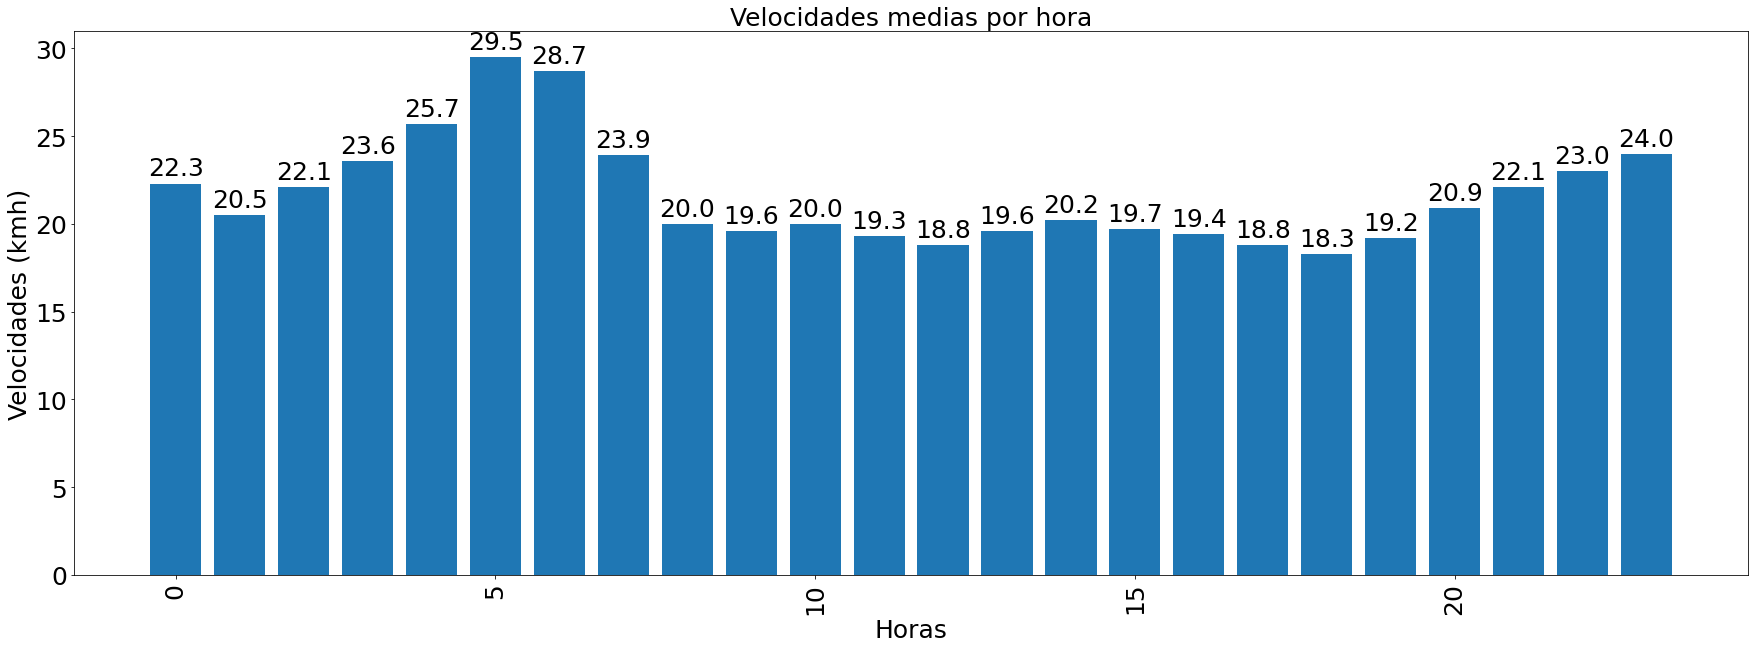

In [20]:
t4velocidades = time()
velocidades_por_hora = spark.sql("""
    SELECT mean_speed, HOUR(tpep_dropoff_datetime) as hour 
      FROM datosCarrerasLimpiosConVelocidad
      WHERE mean_speed <50
""")

velocidades_hora = velocidades_por_hora.groupBy("hour").mean("mean_speed").collect()

t5velocidades=time()

velocidades_x = [round(h,2) for h, cnt in velocidades_hora]
velocidades_y = [round(cnt*3.6,1) for h, cnt in velocidades_hora]

fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(1, 1, 1)
rects1 = ax.bar(velocidades_x, velocidades_y)
ax.set_xlabel("Horas", fontsize=25)
ax.set_ylabel("Velocidades (kmh)", fontsize=25)
ax.set_title("Velocidades medias por hora", fontsize=25)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
autolabel(rects1)

plt.show()

Tras realizar una grafica de velocidades medias por hora se puede observar que cuando las velocidades mas altas son a las horas nocturnas, probablemente porque hay menos trafico y menos vigilancia. 

In [21]:
t_velocidad_media=(t1velocidades-t0velocidades)+(t3velocidades-t2velocidades)+(t5velocidades-t4velocidades)

### Zonas de poca cobertura

Observando la variable `store_and_fwd_flag`, creemos que es posible deducir qué zonas de la ciudad de Nueva York dan un mayor problema a la hora de estar conectados con el servidor de la compañía de taxis, es decir, tienen poca cobertura.

In [22]:
if MODO_JAJAS:
    display(IFrame("https://giphy.com/embed/PmdOx0iRRtqkBFlEgI", width="240", height="240"))

In [23]:
t0_cobertura = time()
sinCobertura_rdd = spark.sql("""
    SELECT DOBorough, DOZone
      FROM datosCarrerasLimpios
      WHERE store_and_fwd_flag == 'Y'
""").rdd

# sC_rdd.flatMap(lambda x: x['locationID']).map(lambda x: (x,1))
zone_tuples = sinCobertura_rdd.map(
    lambda x: (x['DOZone'],1)
).reduceByKey(
    lambda x,y: x+y
).sortBy(
    lambda x: x[1], False
)
borough_tuples = sinCobertura_rdd.map(
    lambda x: (x['DOBorough'],1)
).reduceByKey(
    lambda x,y: x+y
).sortBy(
    lambda x: x[1], False
)

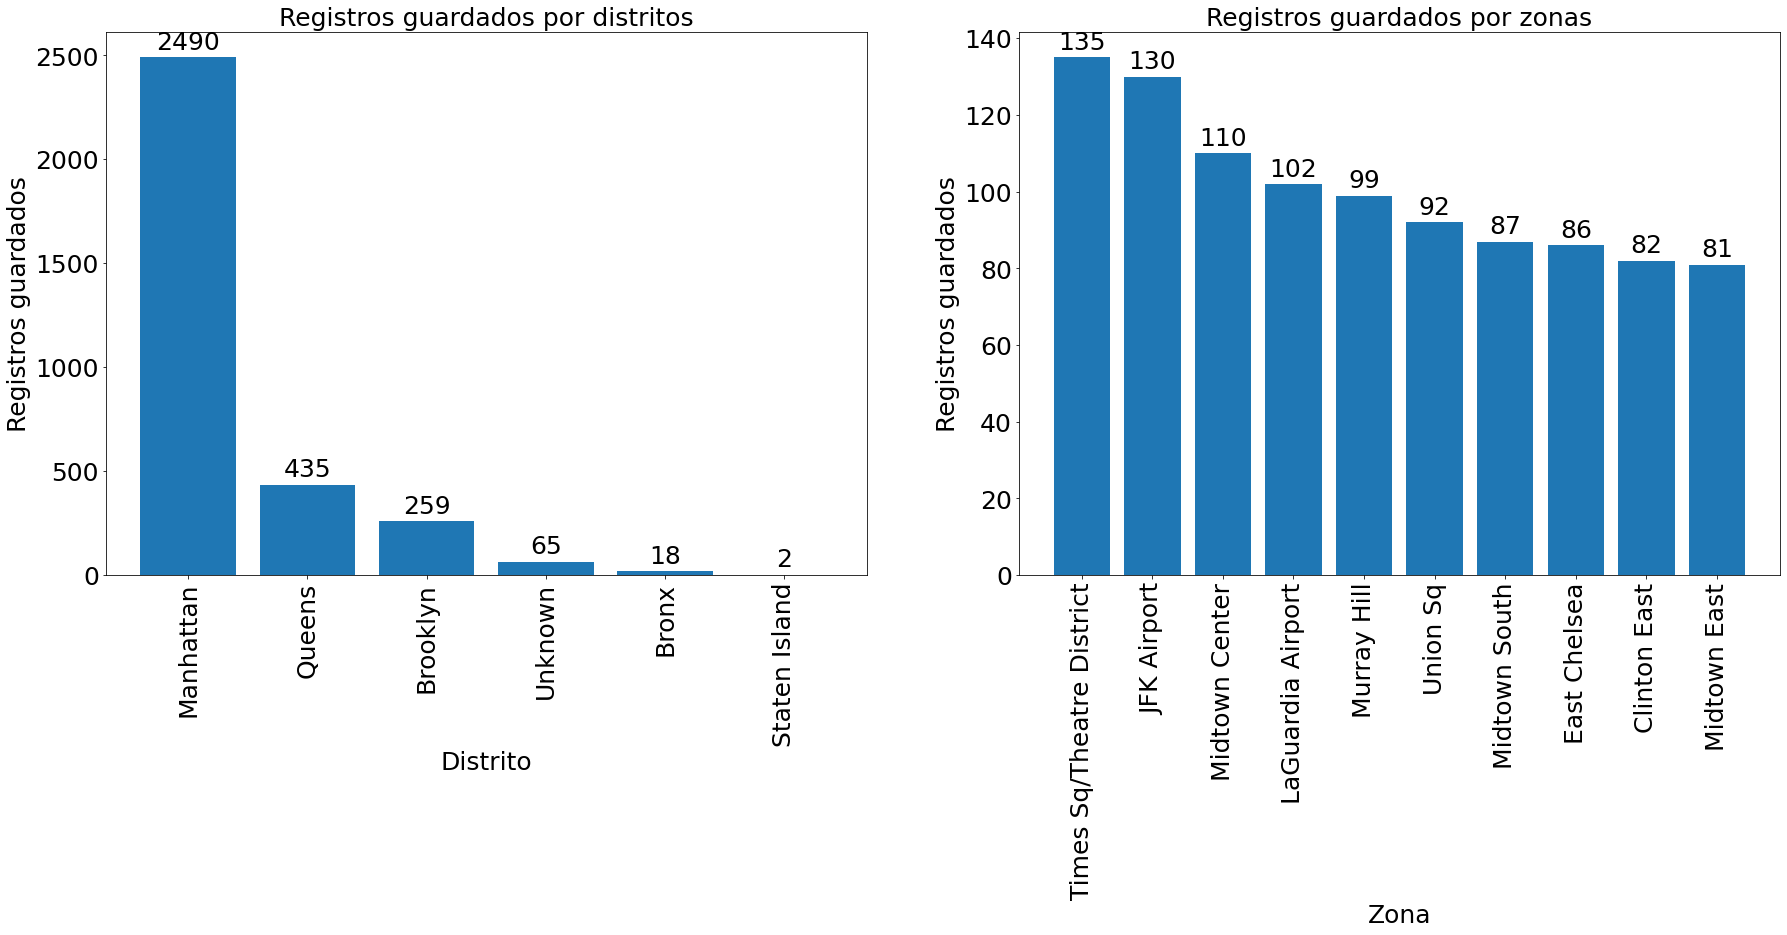

In [24]:
zonas = zone_tuples.take(10)
distritos = borough_tuples.take(10)

distritos_x = [k for k, v in distritos]
distritos_y = [v for k, v in distritos]
zonas_x = [k for k, v in zonas]
zonas_y = [v for k, v in zonas]

fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(1, 2, 1)
rects1 = ax.bar(distritos_x, distritos_y)
ax.set_xlabel("Distrito", fontsize=25)
ax.set_ylabel("Registros guardados", fontsize=25)
ax.set_title("Registros guardados por distritos", fontsize=25)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
autolabel(rects1)

ax = fig.add_subplot(1, 2, 2)
rects2 = ax.bar(zonas_x, zonas_y)
ax.set_xlabel("Zona", fontsize=25)
ax.set_ylabel("Registros guardados", fontsize=25)
ax.set_title("Registros guardados por zonas", fontsize=25)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
autolabel(rects2)

plt.show()

In [25]:
viajes_manhattan = spark.sql("""
    SELECT VendorID
      FROM datosCarrerasLimpios
      WHERE DOBorough == 'Manhattan'
""").count()
int(distritos_y[0])/int(viajes_manhattan)*100

0.2984716811507342

Como se puede apreciar por el número de registros guardados en los taxis, Manhattan es el distrito que tiene más registros guardados con 2490, casi 5 veces más que su distrito posterior, Queens con 435. Por lo que se puede deducir que tiene zonas frecuentadas en las que no se tiene cobertura.

Sin embargo, es un porcentaje pequeño sobre el total, ya que representan menos del 0.3% de todos los viajes existentes que finalizan en Manhattan, por lo que muy probablemente se deba a taxis concretos que tienen problemas de conexión.

Observando que se trata de un porcentaje muy bajo, surge otra pregunta: ¿En qué momento se guardaron los registros? ¿Todos los registros guardados son en horas similares y por tanto puede deberse a una caída del servidor más que a un problema de cobertura?

Para ello se van a analizar los registros de Manhattan ya que son los más numerosos. Para ello nos quedaremos con el día en el que se han guardado el mayor número de mensajes y se analizará en qué horas se han guardado los mensajes, ya que de ser una caída del servidor, deberían agruparse alrededor de una hora concreta.

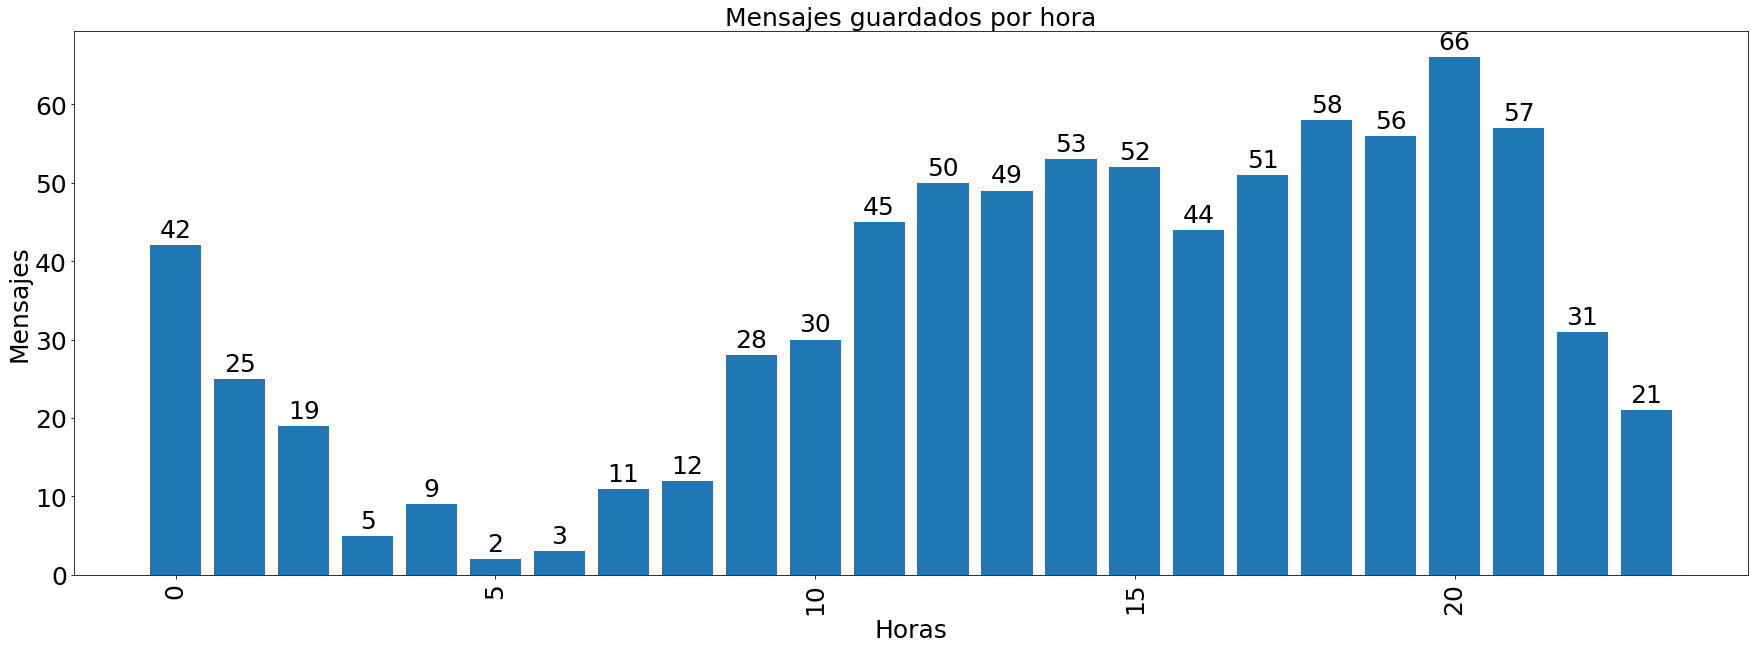


    Se ha tardado 9.16s en realizar este estudio sobre 961150,
    lo que da un procesamiento de 104886.14 dato/seg



In [26]:
stored_manhattan = spark.sql("""
    SELECT tpep_dropoff_datetime, DAY(tpep_dropoff_datetime) as day, HOUR(tpep_dropoff_datetime) as hour
      FROM datosCarrerasLimpios
      WHERE store_and_fwd_flag == 'Y' and DOBorough == 'Manhattan'
""")

# Nos vamos a quedar con el día con mayor número de registros guardados
day, count = stored_manhattan.groupBy("day").count().sort("count").tail(1)[0]

# Ahora que tenemos el día, podemos ver las horas en las que se agruparon los mensajes.
# Si todos (o casi todos) los mensajes se agruparon en la misma hora, eso significa 
# (muy probablemente) que hubo una caída del servidor
mensajes_hora = stored_manhattan.filter(col("day")==day).groupBy("hour").count().collect()
t_cobertura = time() - t0_cobertura

mensajes_x = [h for h, cnt in mensajes_hora]
mensajes_y = [cnt for h, cnt in mensajes_hora]

fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(1, 1, 1)
rects1 = ax.bar(mensajes_x, mensajes_y)
ax.set_xlabel("Horas", fontsize=25)
ax.set_ylabel("Mensajes", fontsize=25)
ax.set_title("Mensajes guardados por hora", fontsize=25)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
autolabel(rects1)

plt.show()

print(f"""
    Se ha tardado {round(t_cobertura, 2)}s en realizar este estudio sobre {datosLimpios_count},
    lo que da un procesamiento de {round(datosLimpios_count/t_cobertura, 2)} dato/seg
""")

Los mensajes guardados se agrupan entre las 10 AM y las 21 PM, pero dado que se corresponde también con el periodo de mayor actividad de los taxis, ya que es cuando la gran mayoría de la población se desplaza por la ciudad, no parece que se deba a una caída del servidor.

Por lo tanto nos reafirmamos en la primera suposición: **Muy probablemente se debe a taxis concretos que tienen problemas de conexión**, no a una caída generalizada. Además si hubiese sido ese el caso, el número de registros debería haber sido muchísimo mayor

### Viajes más comunes

En este apartado se realizará un estudio de los viajes más comunes a realizarse, para esto se tomarán del dataframe los datos referentes a las zonas de los viajes y con esto se hará un modelo sencillo de map-reduce para ver la cantidad de cada viaje.

In [27]:
t0viajesComunes = time()
viajes_comunes = spark.sql("""
    SELECT PUZone, DOZone, PUBorough, DOBorough
      FROM datosCarrerasLimpios 
      WHERE PUBorough != 'Unknown' or DOBorough != 'Unknown'
""")
viajes_comun=viajes_comunes.rdd.map(
    lambda x: (f"De {x['PUZone']}({x['PUBorough']}) a {x['DOZone']}({x['DOBorough']})", 1)
).reduceByKey(
    lambda a,b: a + b
).sortBy(
    lambda x: x[1], False
)

Una aspecto a mencionar antes de continuar es que el viaje mas comun es el de Unknown a Unknown, cosa que no aporta demasiada informacion, por lo tanto estos viajes no se han tenido en cuenta de cara al analisis de los datos.

Tras realizar la organización de los datos en tablas y realizar la reducción, se tomarán los 10 viajes más comunes y se
graficarán como un gráfico de barras horizontal para poder visualizar las diferencias entre la cantidad de estos viajes.


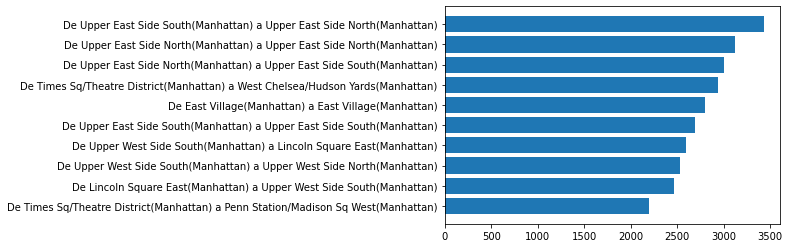

In [28]:
grafica = viajes_comun.take(10)
t1viajesComunes = time()    
x, y = [],[]
for i in grafica:    
    x.append(i[0]),y.append(i[1])
    
plt.figure()
plt.barh(x,y)
plt.gca().invert_yaxis()

In [29]:
t_viajes_comunes=t1viajesComunes-t0viajesComunes

## Propinas

Ahora se va a realizar un estudio sobre las propinas que dejan los pasajeros.
Vamos a empezar contabilizando el numero de propinas que se dejan y clasificarlos por hora, para así poder ver en qué momento del día es más común que se dejen propinas.

In [30]:
if MODO_JAJAS:
    display(IFrame("https://giphy.com/embed/l0HFkA6omUyjVYqw8",width="240", height="135"))

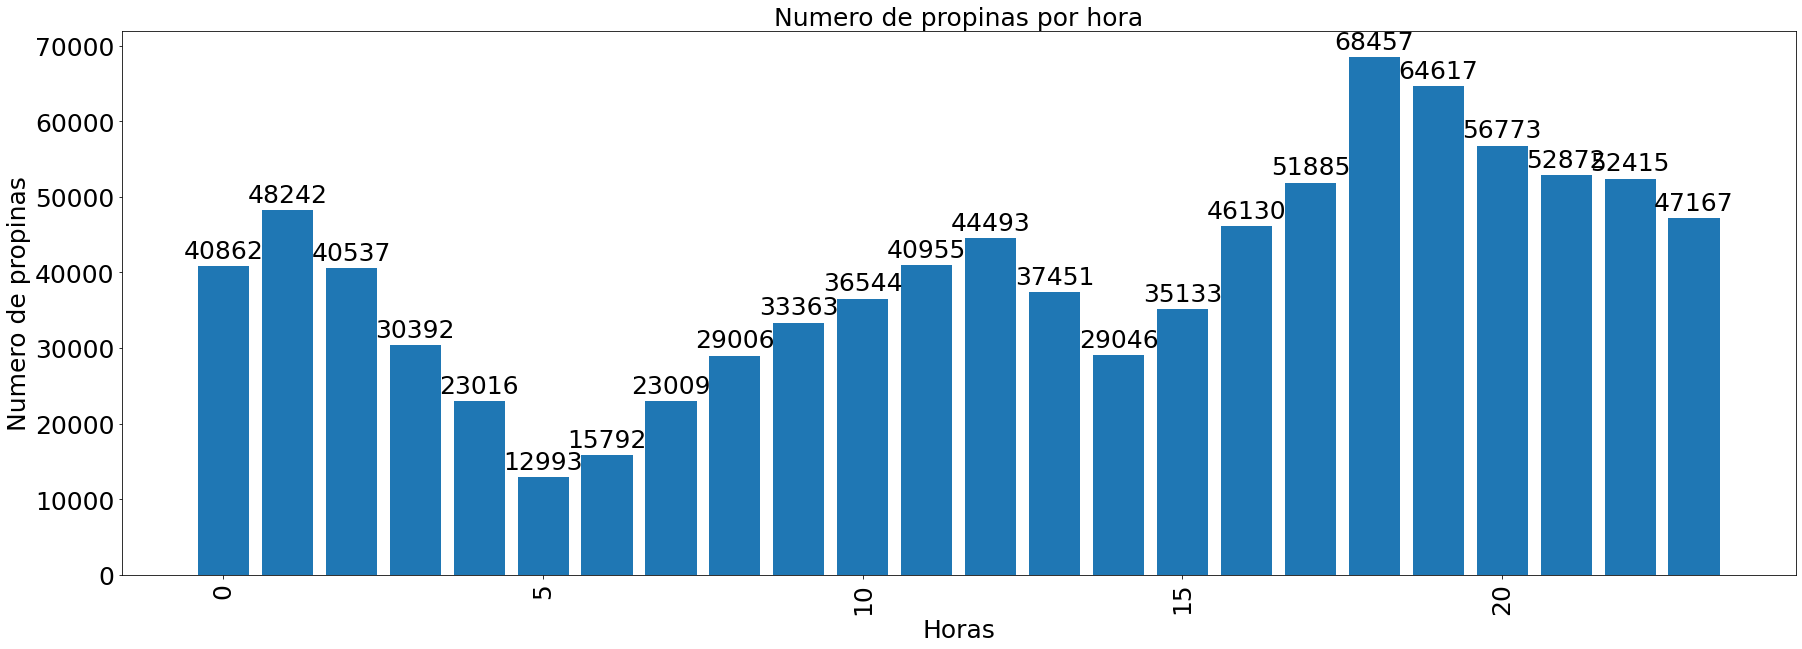

In [31]:
t0Propinas=time()

propinas_hora_query=spark.sql("""
  SELECT tip_amount, HOUR(tpep_dropoff_datetime) as hour 
      FROM datosCarrerasLimpios
""")

propinas_por_hora = propinas_hora_query.groupBy("hour").count().collect()

t1Propinas=time()

propinas_x = [h for h, cnt in propinas_por_hora]
propinas_y = [cnt for h, cnt in propinas_por_hora]

fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(1, 1, 1)
rects1 = ax.bar(propinas_x, propinas_y)
ax.set_xlabel("Horas", fontsize=25)
ax.set_ylabel("Numero de propinas", fontsize=25)
ax.set_title("Numero de propinas por hora", fontsize=25)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
autolabel(rects1)

plt.show()


Como podemos ver, las horas más comunes son las cercanas a las 18h, es decir, a media tarde coincidiendo con la hora de salir de trabajar.

Ahora se va a realizar un estudio de la cantidad de dinero total (en miles de dólares) dejado en cada periodo para ver su similitud con la cantidad de propinas dejadas por hora.

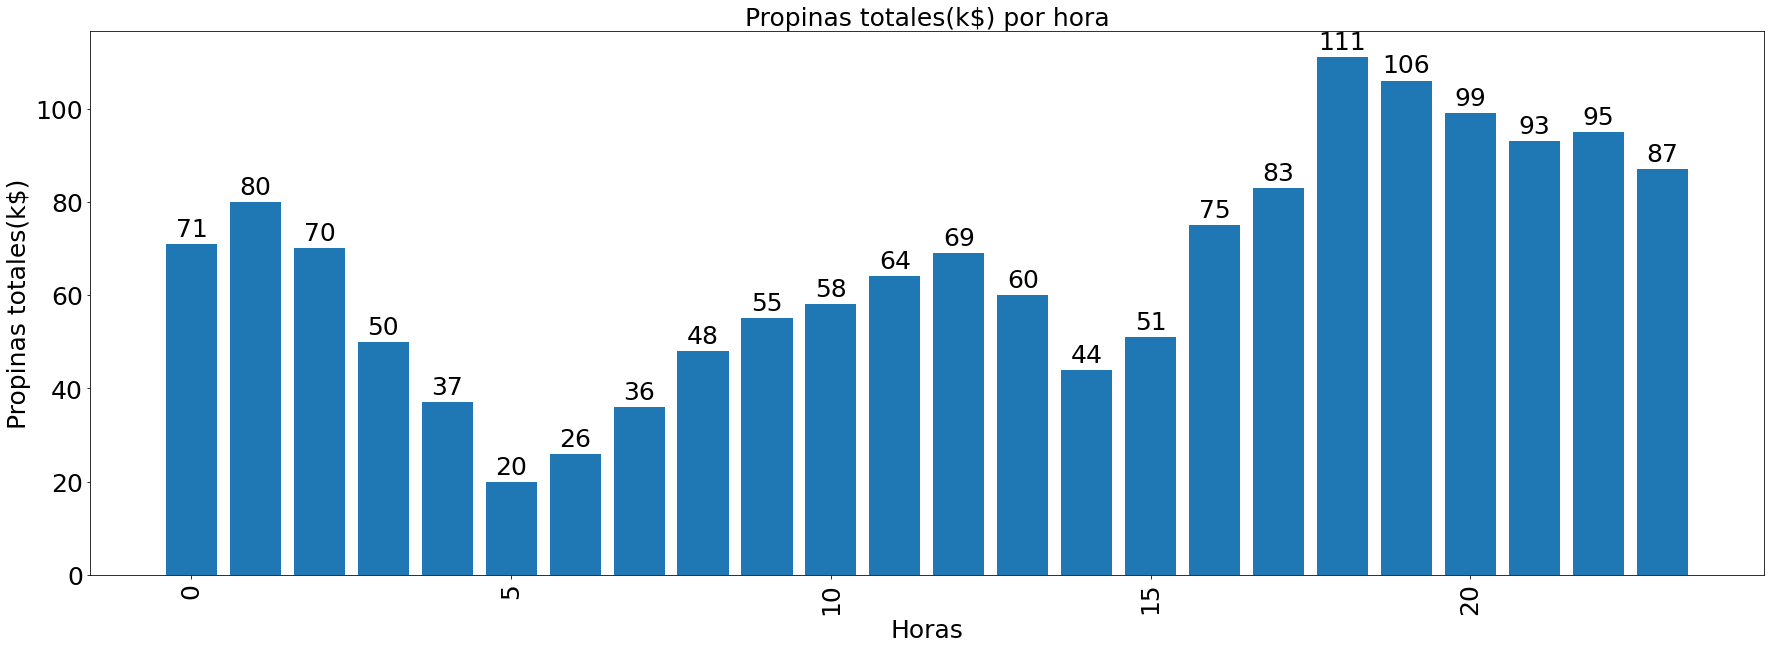

In [32]:
t2Propinas=time()
propinas_totales_por_hora = propinas_hora_query.groupBy("hour").sum('tip_amount').collect()

t3Propinas=time()

propinas_x = [h for h, cnt in propinas_totales_por_hora]
propinas_y = [round(cnt/1000) for h, cnt in propinas_totales_por_hora]

fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(1, 1, 1)
rects1 = ax.bar(propinas_x, propinas_y)
ax.set_xlabel("Horas", fontsize=25)
ax.set_ylabel("Propinas totales(k$)", fontsize=25)
ax.set_title("Propinas totales(k$) por hora", fontsize=25)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
autolabel(rects1)

plt.show()

Como podemos ver, la gráfica resultante es similar a la anterior, por lo que vemos que la cantidad de propinas dejadas tiene relación con la aportación monetaria que producen.

Adicionalmente vamos a hacer un estudio para ver en qué momento del día se dejan las propinas más cuantiosas.

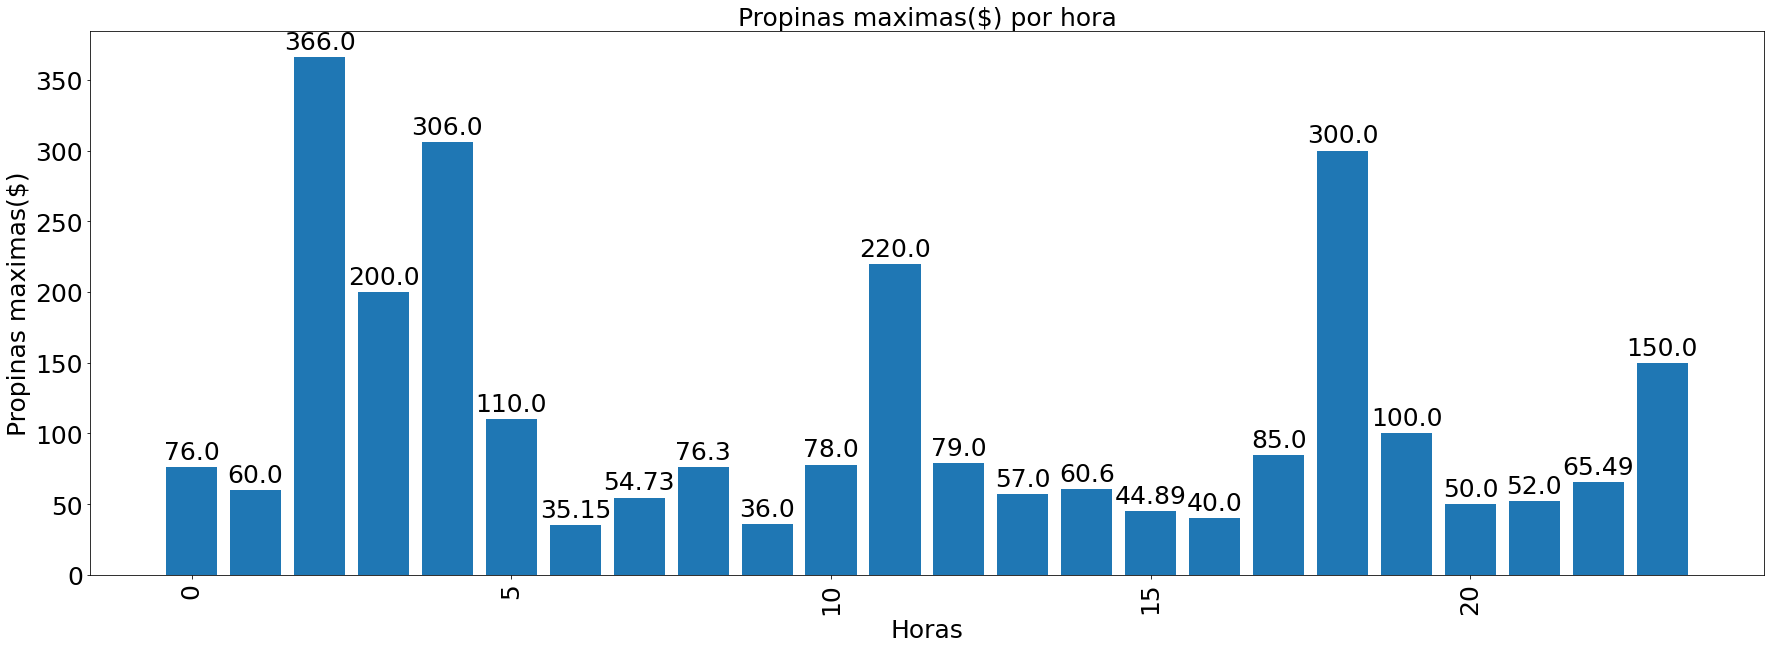

In [33]:
t4Propinas=time()
propinas_maximas_por_hora = propinas_hora_query.groupBy("hour").max('tip_amount').collect()

t5Propinas=time()

propinas_x = [h for h, cnt in propinas_maximas_por_hora]
propinas_y = [cnt for h, cnt in propinas_maximas_por_hora]

fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(1, 1, 1)
rects1 = ax.bar(propinas_x, propinas_y)
ax.set_xlabel("Horas", fontsize=25)
ax.set_ylabel("Propinas maximas($)", fontsize=25)
ax.set_title("Propinas maximas($) por hora", fontsize=25)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
autolabel(rects1)

plt.show()

Como podemos ver, hay propinas muy altas a las horas más comunes, pero otro conjunto de picos en la gráfica, nos indica que de madrugada se dejan también propinas muy cuantiosas, aunque no sean tan numerosas como a media tarde.

In [34]:
tiempoPropinasTotal=(t5Propinas-t4Propinas)+(t3Propinas-t2Propinas)+(t1Propinas-t0Propinas)
print(tiempoPropinasTotal,"Segundos en realizarse el estudio de propinas.")

5.399369478225708 Segundos en realizarse el estudio de propinas.


# Resumen de tiempos, explicación y conclusiones

En esta tabla se recogen todos los tiempos calculados previamente en los estudios realizados.

In [35]:
print(f"""
{"-"*150}
\t\tEstudio\t\t|\tTiempo\t\t|\tVelocidad procesamiento\t\t| Nº Transformaciones-Acciones\t|\tRDD/SQL 
{"-"*150}
{"-"*150}
\tLimpieza\t\t|\t{round(t_limpieza, 2)} s\t\t|\t\t{round(initial_data_count/t_limpieza, 2)}\t\t|\t\t11-4\t\t|\tSQL
{"-"*150}
\tVelocidad media taxis\t|\t{round(t_velocidad_media, 2)} s\t\t|\t\t{round(datosLimpios_count/t_velocidad_media, 2)}\t\t|\t\t4-3\t\t|\tSQL
{"~"*150}
\tZonas sin cobertura\t|\t{round(t_cobertura, 2)} s\t\t|\t\t{round(datosLimpios_count/t_cobertura, 2)}\t\t|\t\t10-7\t\t|\tHibrido
{"~"*150}
\tPropinas\t\t|\t{round(tiempoPropinasTotal, 2)} s\t\t|\t\t{round(datosLimpios_count/tiempoPropinasTotal, 2)}\t\t|\t\t3-6\t\t|\tSQL
{"~"*150}
\tViajes más comunes\t|\t{round(t_viajes_comunes, 2)} s\t\t|\t\t{round(datosLimpios_count/t_viajes_comunes, 2)}\t\t|\t\t3-1\t\t|\tHibrido
{"~"*150}
""")


------------------------------------------------------------------------------------------------------------------------------------------------------
		Estudio		|	Tiempo		|	Velocidad procesamiento		| Nº Transformaciones-Acciones	|	RDD/SQL 
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
	Limpieza		|	20.65 s		|		47028.5		|		11-4		|	SQL
------------------------------------------------------------------------------------------------------------------------------------------------------
	Velocidad media taxis	|	31.26 s		|		30748.97		|		4-3		|	SQL
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
	Zonas sin cobertura	|	9.16 s		|		104886.14	

Como podemos ver, tenemos tiempos bastante dispares entre los distintos estudios.

El más lento es el de "Velocidad media taxis" y el más rápido "viajes más comunes".

La diferencia principal entre los tiempos se debe principalmente a las dos acciones `toPandas` presentes en el estudio de la velocidad, ya que obligan a ejecutar las transformaciones acumuladas sobre todo el dataset (unos 900K registros). Por otro lado en "viajes más comunes" apenas se ejecutan dos acciones poco costosas, obtener el rdd y recuperar los 10 primeros registros. Comparado con recuperar varias veces 900K registros, es poco trabajo.

Uno podría pensar que por número de transformaciones y acciones el estudio "Zonas sin cobertura" sería el que más iba a tardar, no obstante, al igual que con "viajes más comunes", cada vez que se ejecuta una acción se realiza sobre un conjunto de datos muy pequeños en comparación con el dataset global, además de estar muy filtrado, por lo tanto no es el más lento de todos.

# Fin

In [36]:
spark.stop()